In [28]:
import cv2
import numpy as np
from keras import Model, Input
from keras.preprocessing import image
from keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import metrics
import glob
import warnings
warnings.filterwarnings('ignore')


from matplotlib import pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Num GPUs Available:  0


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 17541053193378123181
 xla_global_id: -1]

<Figure size 432x288 with 0 Axes>

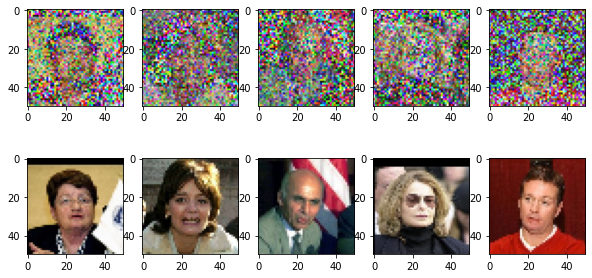

In [32]:
#6.1 Data Preparation

#5.1
# List all filename in face image path
filenames= glob.glob("./face_mini/**/*.jpg")
size = len(filenames)
size
all_imgs = []
for i in range(size):
  # Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
  img = load_img(filenames[i], grayscale=False, color_mode='rgb', target_size = (50,50,3), interpolation="nearest")
  # convert the image to an array
  img = img_to_array(img)
  # Normalized color image
  img = img/255
  all_imgs.append(img)

# convert to numpy array
all_images = np.array(all_imgs)

# split data into train and validation data
x_train, x_test = train_test_split(all_images, random_state=32, test_size=0.3)
x_train, x_val = train_test_split(x_train, random_state=32, test_size=0.3)
# 5.2
# Add Noise กำหนด noise factor (noise level)
# Add noise
noise_factor = 0.2

# กำหนด noise parameter
# Noise distribution: normal
# Noise mean: zero mean (Nmean = 0)
# Noise std: unit variance (Nstd = 1)
Nmean = 0
Nstd = 1

# use np.random.normal to generate normal distribution (gaussian) noise
x_train_noisy = x_train + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_train.shape))
x_val_noisy = x_val + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_val.shape))
x_test_noisy = x_test + (noise_factor * np.random.normal(loc=Nmean, scale=Nstd, size=x_test.shape) )

#display noisy images
plt.figure()
f1, ax1 = plt.subplots(2,5,figsize=(10,5)) 
for i in range(5):
  ax1[0][i].imshow((x_train_noisy[i]* 255).astype(np.uint8))
  ax1[1][i].imshow((x_train[i]* 255).astype(np.uint8))

In [33]:
#6.2 Model Architecture -> create_model/ KerasRegressor

# create_model function
def create_model(optimizer='adam'):
    Input_img = Input(shape=x_train_noisy[0].shape)

    # encoder layers
    #encoding architecture
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(Input_img)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
    x2 = MaxPool2D( (2, 2))(x2)
    encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

    # decoding architecture
    x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
    x3 = UpSampling2D((2, 2))(x3)
    x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
    x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(x2)
    decoded = Conv2D(3, (3, 3), padding='same')(x1)

    # construct the autoencoder model
    autoencoder = Model(Input_img, decoded)
    autoencoder.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mean_squared_error'])

    return autoencoder

In [34]:
# ประกําศ KERAS ตัวจัดกํารพํารํามิเตอร์ของ Model
model = KerasRegressor(build_fn=create_model, epochs=2, batch_size=16, verbose=0)
#6.3 (a) Create GridSearchCV()

# กำหนด Grid Search parameters
optimizer = ['SGD', 'RMSprop', 'Adadelta', 'Adam']
batch_size = [8, 16, 32]
epochs = [2,4,6]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer=optimizer)

grid = GridSearchCV(estimator=model, verbose= 0, cv=2, param_grid = param_grid)

grid_result = grid.fit(x_train_noisy, x_train)

print('Best params: ',grid_result.bestparams)
print('Best score: ', grid_result.bestscore)

means = grid_result.cvresults['mean_test_score']
stds = grid_result.cvresults['std_test_score']
params = grid_result.cvresults['params']

# Display Statistics view
# Error results from All combinations of grid parameters -> plot() หรือ bar()
#6.3 (b) Create RandomizedSearchCV()

# กำหนด Grid Search parameters
random_search = {'optimizer': ['SGD', 'RMSprop', 'Adadelta', 'Adam'],
                 'batch_size': list(np.linspace(8, 64, 5, dtype = int)),
                 'epochs': list(np.linspace(1, 10, 4, dtype = int))}

grid_rand = RandomizedSearchCV( estimator=model, verbose= 0, cv=2, random_state = 10, n_iter = 10,) # จ ํานวน random parametersparam_grid = param_grid,)

grid_rand_result = grid_rand.fit(x_train_noisy, train_x)

print('Best params: ',grid_rand_result.bestparams)
print('Best score: ', grid_rand_result.bestscore)

means = grid_result.cvresults['mean_test_score']
stds = grid_result.cvresults['std_test_score']
params = grid_result.cvresults['params']
# Display Statistics view
# • Error results from All combinations of grid parameters > plot() หรือ bar()

KeyboardInterrupt: 